In [9]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
import logging
import os
import nevergrad as ng
from concurrent import futures
import time
import networkx as nx
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
import sklearn.svm as svm
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

logger = logging.getLogger(__name__)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "WARNING"))

from common import *
from helpers import *

In [10]:
df = make_df_from_sheet(r"data/GWTC_2021_Master.csv") # read the file
df.head(n=1)

,id (Event ID),commonName (Event Name),Classification,version,catalog.shortName,GPS,Mass_1_source (solar masses),mass_1_source_upper_error,Mass_1_Upper Limit (solar masses),mass_1_source_lower_error,...,redshift_upper_limit,far,far_lower,far_upper,p_astro,p_astro_lower,p_astro_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
0,GW150914-v3,GW150914,Black Hole (High Mass),3,GWTC-1-confident,1126259462,35.6,4.7,40.3,-3.1,...,0.12,1.000000e-07,NaN,NaN,1.0,NaN,NaN,63.1,-3.0,3.4


In [98]:
def filter_bh(df): 
    # returns indexes of bh items
    return df.Classification.str.contains("Black Hole")

def filter_ns(df):
    return df.Classification.str.contains("Neutron Star")

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


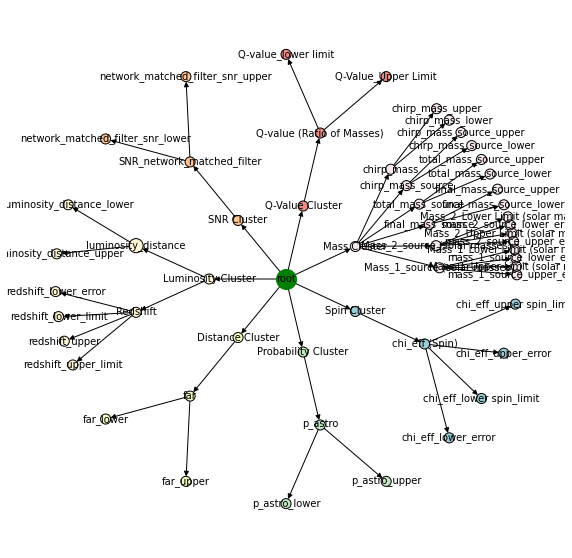

In [11]:
# load the heirarchy file. 
hierarchy_file = r'data/gwtc_heirarchy_pretty.json'
hft = BaseOntologyTransform(mapping=json.load(open(hierarchy_file, "r")))
processed_df, y, alldf, ids = preprocess(df)

# plot the heirarchy
fig, ax = plt.subplots(figsize=(10,10))
g = hft.transform(processed_df.iloc[0])
draw_graph(g , ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False)  
plt.savefig("rendered/heirarchy_graph.png")

In [74]:
df.Classification.unique()

array(['Black Hole (High Mass)', 'Black Hole (Low Mass)', 'Neutron Star',
       'Neutron Star + Black Hole', 'PBH Candidate'], dtype=object)

In [4]:
opts = {
    "chi_eff (Spin)": [-0.1, 0.1],
    "Q-value (Ratio of Masses)": [.01, .88]
}

def make_linkers_and_filters(graph, opts={}):
    '''
    Defaults all filters to be a range filter. And the linker to be a simple child linker. 
    '''
    ENDL = " | " 
    filters, linkers = {}, {}
    for k, v in graph.nodes.items():
        if 'value' in v and isinstance(v['value'], numbers.Number):
            if v["id"] in opts:
                print("Set {:s} from options".format(v["id"]), end=ENDL)
            else:
                print("Set {:s} to default".format(v["id"]), end=ENDL)
            minv, maxv = opts.get(v["id"][0], 0), opts.get(v["id"][1], 1)
            filters[k] = RangeFilter(min=minv, max=maxv)        
    linkers['root'] = SimpleChildLinker()
    return filters, linkers

filters, linkers = make_linkers_and_filters(g, opts)

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) from options | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_lower to default | Set luminosit

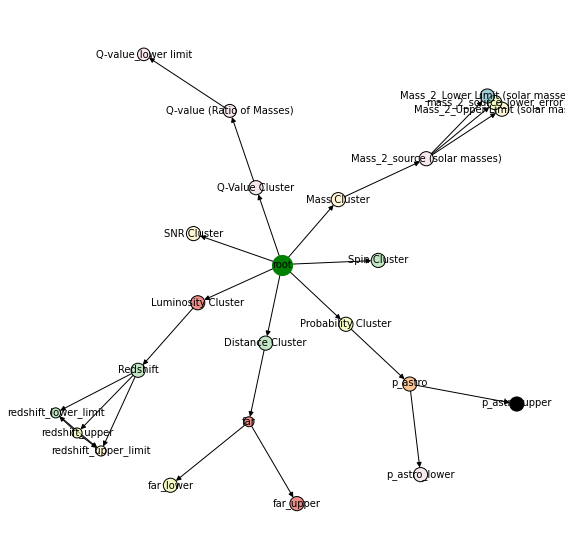

In [5]:
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
g2 = pipeline.transform(g, is_base=False)
fig, ax = plt.subplots(figsize=(10,10))
draw_rk_diagram(g2, ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False)  
plt.savefig("rendered/rk_graph1.png")

## Untuned Visualizations

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_lower to default | Set luminosity_

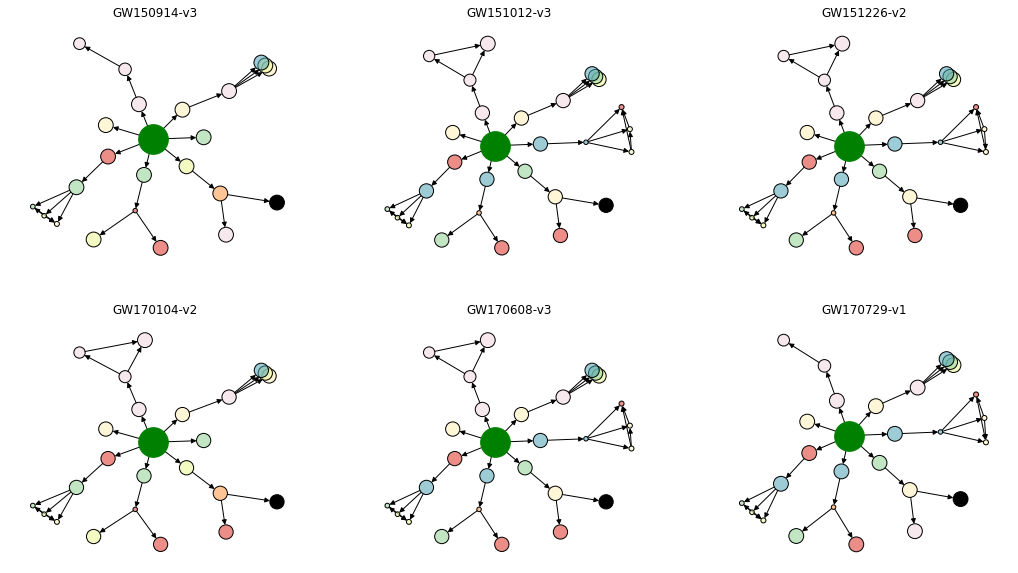

In [13]:
# completely untuned
f, l = make_linkers_and_filters(g, {})
n = 6
pipeline = RKPipeline(filter_map=f, linkage_map=l, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
mdist = compute_distance(processed_df)
distances = compute_distances(rkmodels, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

Average similarity of graphs pre tuned: 0.9168172361264453


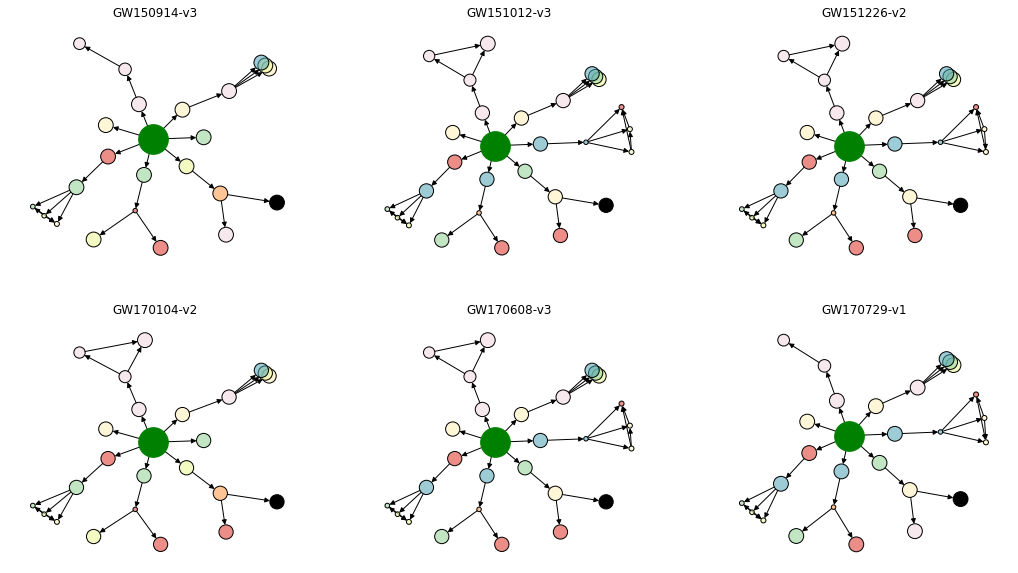

In [14]:
n = 6
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
mdist = compute_distance(processed_df)
distances = compute_distances(rkmodels, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

In [ ]:
selected_events = ["GW170729", "GW170817", "GW190814", "GW190521"]
subset_df = df[df["commonName (Event Name)"].isin(selected_events)]
label_df = df.iloc[subset_df.index]

def build_4_model(pipeline, title, filename):
    n = 4
    rkmodels = make_n_rkmodels(processed_df, alldf,hft, pipeline, n=n, indexes=list(subset_df.index))
    print("Processed {} rk models from {}".format(len(rkmodels), len(processed_df)))
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    
    plt.savefig("rendered/untuned_{}_{}.png".format(filename, n))
    plt.show()
    print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))
    

## Tuning

Iteration: 00100. Loss: 0.87424474. ITime 29.54 seconds. Total time: 29.96
Iteration: 00200. Loss: 0.90360624. ITime 28.92 seconds. Total time: 58.87
Iteration: 00300. Loss: 0.93705314. ITime 29.91 seconds. Total time: 88.78
Iteration: 00400. Loss: 0.85295638. ITime 29.61 seconds. Total time: 118.40
Iteration: 00500. Loss: 0.95129870. ITime 31.61 seconds. Total time: 150.01
Iteration: 00600. Loss: 0.93969346. ITime 29.92 seconds. Total time: 179.93
Iteration: 00700. Loss: 0.93636364. ITime 18.95 seconds. Total time: 198.89
Iteration: 00800. Loss: 0.96306240. ITime 20.48 seconds. Total time: 219.36
Iteration: 00900. Loss: 0.92810458. ITime 30.18 seconds. Total time: 249.54
Iteration: 01000. Loss: 0.88148962. ITime 30.75 seconds. Total time: 280.29
Iteration: 01100. Loss: 0.90872214. ITime 29.38 seconds. Total time: 309.68
Iteration: 01200. Loss: 0.91030536. ITime 19.33 seconds. Total time: 329.00
Iteration: 01300. Loss: 0.92390212. ITime 26.00 seconds. Total time: 355.01
Iteration: 0140

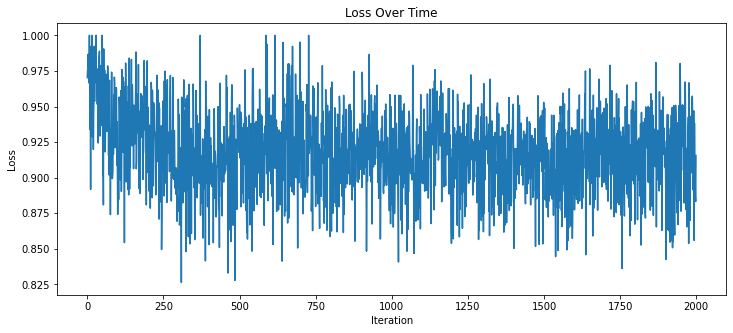

<Figure size 432x288 with 0 Axes>

In [17]:
w0 = pipeline.get_w()
weights, history = train(len(w0[0]), pipeline, processed_df, hft, mdist)
show(weights, history, pipeline, processed_df, hft, w0)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Average similarity of graphs tuned: 0.928380781682552


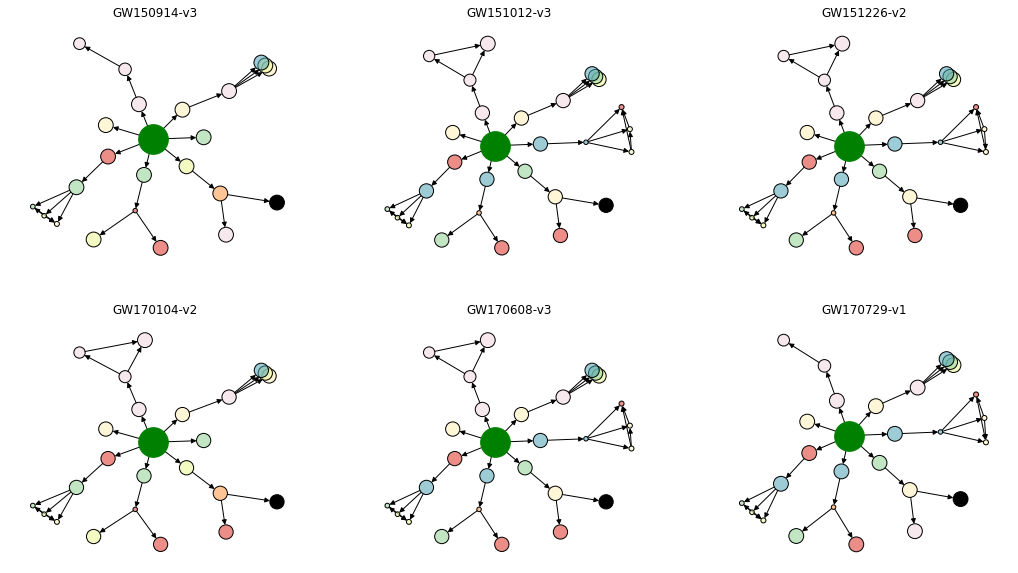

In [24]:
def run6(filters, linkers, g, processed_df, alldf, hft, pipeline):
    n = 6
    pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
    rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    plt.savefig("rendered/untuned_{}.png".format(n))
    print("Average similarity of graphs tuned: {}".format(1 - np.mean(distances)))
    
run6(filters, linkers, g, processed_df, alldf, hft, pipeline)

### Classification

In [25]:
def build_classification_data(processed_df, y, alldf, hft, pipeline):
    n = len(processed_df)

    start = time.time()
    rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
    t = time.time() - start
    print("Making rk models. Took {} seconds. {} seconds Per model".format(t, t/n))

    start = time.time()
    X = [ extract_rk_features(rk) for rk in rkmodels ]
    t = time.time() - start
    print("Extracted features. Took {} seconds. {} seconds Per model".format(t, t/n))
    return train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def classify1(X_train, X_test, y_train, y_test):
    
    encoder = LabelEncoder()
    y = encoder.fit_transform(y_train.str.strip())
    
    clf = OneVsRestClassifier(
        svm.SVC(kernel="linear", probability=True, random_state=1)
    )

    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)

    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    print(classification_report(y_test, predicted, target_names=encoder.classes_))
X_train, X_test, y_train, y_test = build_classification_data(processed_df, y, alldf, hft, pipeline)
classify1(X_train, X_test, y_train, y_test)

Making rk models. Took 0.7158298492431641 seconds. 0.00786626207959521 seconds Per model
Extracted features. Took 14.46918511390686 seconds. 0.1590020342187567 seconds Per model
                           precision    recall  f1-score   support

   Black Hole (High Mass)       0.70      0.89      0.78        18
    Black Hole (Low Mass)       0.40      0.29      0.33         7
             Neutron Star       0.00      0.00      0.00         1
Neutron Star + Black Hole       0.00      0.00      0.00         1
            PBH Candidate       0.00      0.00      0.00         1

                 accuracy                           0.64        28
                macro avg       0.22      0.23      0.22        28
             weighted avg       0.55      0.64      0.59        28



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
subsets = [ ("Neutron Star", filter_ns(df),y_train.str.contains("Neutron Star"), y_test.str.contains("Neutron Star")),
            ("Black Hole", filter_bh(df),y_train.str.contains("Black Hole"), y_test.str.contains("Black Hole")),
            ("All", [True] * len(df), [True] * len(y_train), [True] * len(y_test))]
#subsets = subsets[0]

def print_bold(s):
    print('\033[1m' + s + '\033[0m')
    
def show_models(pipeline, title, filename, processed_df, alldf, hft, n=4):
    subset_df = alldf
    rkmodels = make_n_rkmodels(processed_df, alldf,hft, pipeline, n=n, indexes=range(0,len(alldf)))
    print_bold("Processed {} rk models from {}".format(len(rkmodels), len(processed_df)))
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    #plt.savefig("rendered/untuned_{}_{}.png".format(filename, n))
    #plt.show()
    print_bold("Average similarity {}: {}".format(title, 1 - np.mean(distances)))
    
for s in subsets:
    print_bold("Working on subset " + s[0])
    pdf2 = processed_df[s[1]]
    df2 = df[s[1]]
    f, l = make_linkers_and_filters(g, {})
    untuned_pipeline = RKPipeline(filter_map=f, linkage_map=l, structural_graph=g)
    show_models(untuned_pipeline, "Untuned + No Domain Expertise ", s[0] + "_untuned_no_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )
    pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
    show_models(pipeline, "Untuned + Domain Expertise", s[0] + "_untuned_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )
    show_models(pipeline.remap(weights, w0[1]),  "Tuned + Domain Expertise", s[0] + "_tuned_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )


Working on subset Neutron Star
Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_low